In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.io.arff import loadarff
%matplotlib inline

### Линейная регрессия: прогнозирование преступности

#### Описание набора данных

**Предикторы.** Переменные, включенные в набор данных, включают характеристики сообщества, например, процент населения, считающегося городским, и средний доход семьи, а также характеристики правоохранительных органов, такие как количество полицейских на душу населения и процент сотрудников, работающих в подразделениях по борьбе с наркотиками. Информация о датасете:
- http://archive.ics.uci.edu/ml/datasets/communities+and+crime

**Целевой признак.** Переменная количества насильственных преступлений на душу населения рассчитывалась с использованием численности населения и суммы преступлений: убийство, изнасилование, грабеж и нападение. В некоторых штатах, по-видимому, возникли разногласия по поводу подсчета изнасилований. Это привело к отсутствию значений для изнасилования, что привело к неправильным значениям для преступлений на душу населения. Эти города не включены в набор данных. Переменная в базе:
- ViolentCrimesPerPop: total number of violent crimes per 100K popuation (numeric - decimal)

In [2]:
from crime_dataset_headers import *

data_url= 'https://archive.ics.uci.edu/ml/machine-learning-databases/communities/communities.data'
crime = pd.read_csv(data_url, header=None, names=headers, na_values='?', index_col='communityname')

In [3]:
# Удалим значения тех переменных, которые не являются содержательными для задач предсказания
non_predictive = ['state','county', 'community', 'fold']
crime.drop(non_predictive, axis=1, inplace=True)

# Заполним пропущенные значения
crime.loc['Natchezcity','OtherPerCap'] = crime['OtherPerCap'].mean()

# Удалим колонки, для которых имеется очень много пропущенных значений
missing_values_per_col = crime.isnull().sum()
cols_to_remove = missing_values_per_col[missing_values_per_col > 0].index
crime.drop(cols_to_remove, axis=1, inplace=True)

Нам нужно:
1. Так как признаков очень много, давайте попробуем проделать процедуру предсказания используя как все признаки, так и только часть. Для начала отберем топ-10 признаков, которые сильнее всего коррелируют с целевым признаком;
2. Подготовим данные для моделирования, сохранив отдельно предикторы и целевой признак. Разделим выборку на тестовую и тренировочную (параметры: `test_size=0.2, random_state=123`);
3. Создадим таблицу, куда мы будем сохранять меры качества модели на тренировочной выборке, обученной с использованием топ-10 и всех признаков;
4. Обучим простую модель предсказания среднего, множественную регрессию и множественную регрессию с регуляризацией (Lasso, `alpha=0.0005`);
5. Сохраним меры качества;
6. Повторим шаги 2-4, используя весь набор предикторов и сохраним меры качества;
7. На одном графике визуализируем меры качества для трех моделей, обученных на топ-10 признаках и всем наборе данных;
8. Выберем лучшую модель и предскажем значение преступности для `new_city`.

In [4]:
import seaborn as sns 
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import RobustScaler #подгрузим библиотеки для визуализации и обучения

In [5]:
corr_crime = crime.corr() #Линейная корреляция по Пирсону
corr_crime = corr_crime.loc['ViolentCrimesPerPop'] #лочимся на корреляциях с краймом
corr_crime = pd.DataFrame(corr_crime)    #делаем датафрейм
corr_crime['abs'] = corr_crime['ViolentCrimesPerPop'].apply(lambda x: abs(x)) 
# работаем с модулями, так как важна только сила корреляции.
# Через лямбду преобразовывем каждый элемент и делаем новый столбик - абсолют чисел
    
corr_crime = corr_crime.sort_values(['abs']) #сортируем по порядку
corr_crime[90:100] #отобрали 10 признаков (101 признак - это корреляция крайма с краймом)

,ViolentCrimesPerPop,abs
FemalePctDiv,0.556032,0.556032
pctWPubAsst,0.574665,0.574665
pctWInvInc,-0.576324,0.576324
racepctblack,0.631264,0.631264
PctTeen2Par,-0.661582,0.661582
PctYoungKids2Par,-0.666059,0.666059
racePctWhite,-0.684770,0.684770
PctFam2Par,-0.706667,0.706667
PctIlleg,0.737957,0.737957
PctKids2Par,-0.738424,0.738424


In [6]:
new_crime = crime[['FemalePctDiv']] 

for i in corr_crime.index[91:101]: # переносим столбцы, идентичные найденным нами релевантным индексам
    new_crime[i] = crime[[i]]
    
new_crime[:3] #теперь у нас есть датафрейм для работы

B:\python\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


,FemalePctDiv,pctWPubAsst,pctWInvInc,racepctblack,PctTeen2Par,PctYoungKids2Par,racePctWhite,PctFam2Par,PctIlleg,PctKids2Par,ViolentCrimesPerPop
communityname,,,,,,,,,,,
Lakewoodcity,0.75,0.15,0.60,0.02,0.56,0.61,0.90,0.55,0.14,0.59,0.20
Tukwilacity,0.91,0.29,0.45,0.12,0.39,0.60,0.74,0.43,0.24,0.47,0.67
Aberdeentown,0.71,0.40,0.39,0.49,0.43,0.43,0.56,0.42,0.46,0.44,0.43


In [7]:
target_name = 'ViolentCrimesPerPop' 
robust_scaler = RobustScaler() 

X = new_crime.drop('ViolentCrimesPerPop', axis=1)
X = robust_scaler.fit_transform(X)

y = new_crime[target_name]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

In [8]:
models = pd.DataFrame(index=['train_mse','test_mse'], 
                          columns=['NULL top-10', 'MLR top-10', 'LASSO top-10', 'NULL all', 'MLR all', 'LASSO all'])

In [9]:
y_pred_null = y_train.mean() 
#простая модель 

models.loc['train_mse','NULL top-10'] = mean_squared_error(y_pred=np.repeat(y_pred_null, y_train.size), 
                                                   y_true=y_train)

models.loc['test_mse','NULL top-10'] = mean_squared_error(y_pred=np.repeat(y_pred_null, y_test.size), 
                                                   y_true=y_test)

In [10]:
from sklearn.linear_model import LinearRegression
#множественная линейная регрессия
linear_regression = LinearRegression()
linear_regression.fit(X_train, y_train)

models.loc['train_mse','MLR top-10'] = mean_squared_error(y_pred=linear_regression.predict(X_train), 
                                                    y_true=y_train)

models.loc['test_mse','MLR top-10'] = mean_squared_error(y_pred=linear_regression.predict(X_test), 
                                                   y_true=y_test)

In [11]:
from sklearn.linear_model import Lasso
#лассо
lasso = Lasso(alpha=0.05)
lasso.fit(X_train, y_train)

models.loc['train_mse','LASSO top-10'] = mean_squared_error(y_pred=lasso.predict(X_train), 
                                                    y_true=y_train)

models.loc['test_mse','LASSO top-10'] = mean_squared_error(y_pred=lasso.predict(X_test), 
                                                   y_true=y_test)

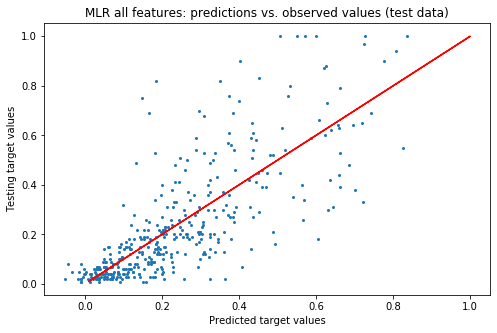

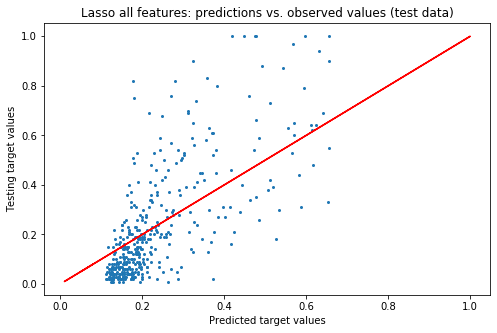

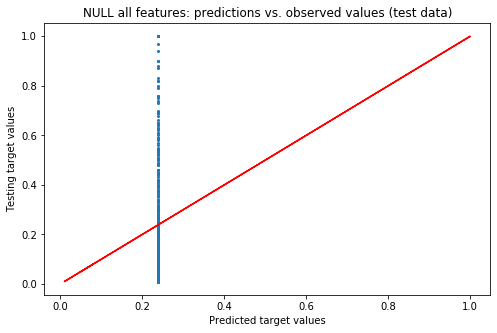

In [12]:
fig, ax = plt.subplots(figsize=(8,5))
ax.scatter(linear_regression.predict(X_test), y_test, s=4)
ax.plot(y_test, y_test, color='red')
ax.set_title('MLR all features: predictions vs. observed values (test data)')
ax.set_xlabel('Predicted target values')
ax.set_ylabel('Testing target values');

fig, ax = plt.subplots(figsize=(8,5))
ax.scatter(lasso.predict(X_test), y_test, s=4)
ax.plot(y_test, y_test, color='red')
ax.set_title('Lasso all features: predictions vs. observed values (test data)')
ax.set_xlabel('Predicted target values')
ax.set_ylabel('Testing target values');

fig, ax = plt.subplots(figsize=(8,5))
ax.scatter(np.repeat(y_pred_null, y_test.size), y_test, s=4)
ax.plot(y_test, y_test, color='red')
ax.set_title('NULL all features: predictions vs. observed values (test data)')
ax.set_xlabel('Predicted target values')
ax.set_ylabel('Testing target values');

#визуализируем наши предсказания. Видим, что простая модель работает плохо

In [13]:
#а теперь для всех

target_name = 'ViolentCrimesPerPop' 
robust_scaler = RobustScaler()

X = crime.drop('ViolentCrimesPerPop', axis=1)
X = robust_scaler.fit_transform(X)

y = crime[target_name]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

In [14]:
y_pred_null = y_train.mean() 

models.loc['train_mse','NULL all'] = mean_squared_error(y_pred=np.repeat(y_pred_null, y_train.size), 
                                                   y_true=y_train)

models.loc['test_mse','NULL all'] = mean_squared_error(y_pred=np.repeat(y_pred_null, y_test.size), 
                                                   y_true=y_test)

In [15]:
linear_regression = LinearRegression()
linear_regression.fit(X_train, y_train)

models.loc['train_mse','MLR all'] = mean_squared_error(y_pred=linear_regression.predict(X_train), 
                                                    y_true=y_train)

models.loc['test_mse','MLR all'] = mean_squared_error(y_pred=linear_regression.predict(X_test), 
                                                   y_true=y_test)

In [16]:
lasso = Lasso(alpha=0.05)
lasso.fit(X_train, y_train)

models.loc['train_mse','LASSO all'] = mean_squared_error(y_pred=lasso.predict(X_train), 
                                                    y_true=y_train)

models.loc['test_mse','LASSO all'] = mean_squared_error(y_pred=lasso.predict(X_test), 
                                                   y_true=y_test)

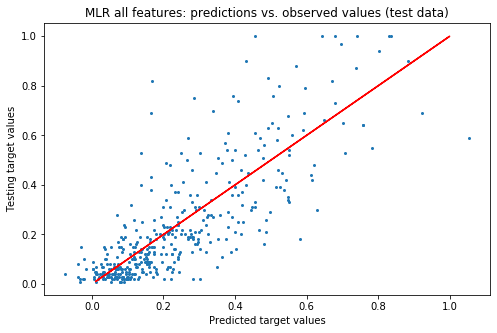

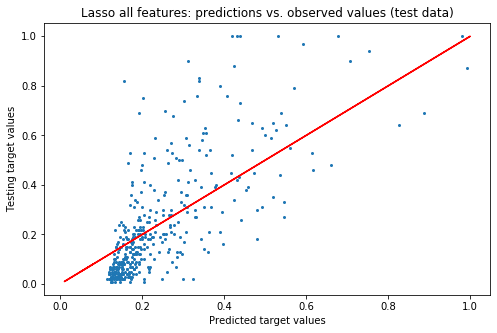

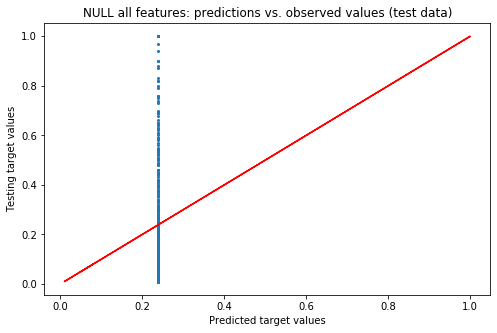

In [17]:
fig, ax = plt.subplots(figsize=(8,5))
ax.scatter(linear_regression.predict(X_test), y_test, s=4)
ax.plot(y_test, y_test, color='red')
ax.set_title('MLR all features: predictions vs. observed values (test data)')
ax.set_xlabel('Predicted target values')
ax.set_ylabel('Testing target values');

fig, ax = plt.subplots(figsize=(8,5))
ax.scatter(lasso.predict(X_test), y_test, s=4)
ax.plot(y_test, y_test, color='red')
ax.set_title('Lasso all features: predictions vs. observed values (test data)')
ax.set_xlabel('Predicted target values')
ax.set_ylabel('Testing target values');

fig, ax = plt.subplots(figsize=(8,5))
ax.scatter(np.repeat(y_pred_null, y_test.size), y_test, s=4)
ax.plot(y_test, y_test, color='red')
ax.set_title('NULL all features: predictions vs. observed values (test data)')
ax.set_xlabel('Predicted target values')
ax.set_ylabel('Testing target values'); 

In [18]:
#линейная регрессия лучше всех, на полной выборке - наименьший mean squared error (MLR all оптимально)
models 

,NULL top-10,MLR top-10,LASSO top-10,NULL all,MLR all,LASSO all
train_mse,0.0545435,0.0206149,0.0268049,0.0545435,0.0162874,0.0247522
test_mse,0.0531034,0.0215353,0.0273755,0.0531034,0.019051,0.0253824


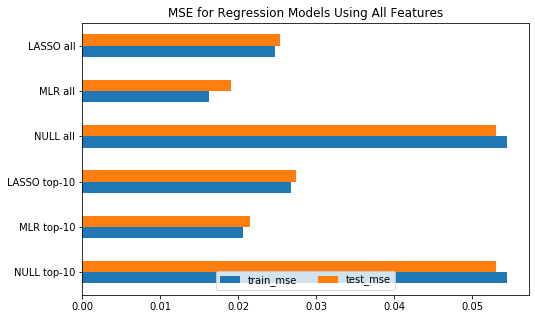

In [19]:
#делаем модель, визуально подтверждаем вывод
fig, ax = plt.subplots(figsize=(8,5)) 
models.T.plot(kind='barh', ax=ax)
ax.set_title('MSE for Regression Models Using All Features')
ax.legend(loc=8, ncol=5);

In [20]:
# Для этого города будем предсказывать значение преступности
new_city = crime.iloc[10].drop('ViolentCrimesPerPop')
new_city

population               0.13
householdsize            0.71
racepctblack             0.15
racePctWhite             0.07
racePctAsian             1.00
racePctHisp              0.41
agePct12t21              0.40
agePct12t29              0.52
agePct16t24              0.35
agePct65up               0.33
numbUrban                0.15
pctUrban                 1.00
medIncome                0.49
pctWWage                 0.71
pctWFarmSelf             0.16
pctWInvInc               0.47
pctWSocSec               0.36
pctWPubAsst              0.40
pctWRetire               0.45
medFamInc                0.47
perCapInc                0.33
whitePerCap              0.37
blackPerCap              0.40
indianPerCap             0.22
AsianPerCap              0.32
OtherPerCap              0.34
HispPerCap               0.38
NumUnderPov              0.06
PctPopUnderPov           0.18
PctLess9thGrade          0.33
                         ... 
MedNumBR                 0.00
HousVacant               0.06
PctHousOcc

In [21]:
#предсказываем по всем признакам
new_city = pd.Series(new_city).values.reshape(1,-1) 

In [22]:
pred=linear_regression.predict(new_city)
print('предсказанное значение для выбранного вами города: ', pred) 
#в реальности ~24, предсказали ~22. Близкий результат

предсказанное значение для выбранного вами города:  [0.21772718]


### Логистическая регрессия: прогнозирование банкротства 

#### Описание набора данных

Набор данных о прогнозировании банкротства польских компаний. Данные были получены от Информационной службы развивающихся рынков (EMIS), и представляют собой базу данных, содержащую информацию о развивающихся рынках по всему миру. Обанкротившиеся компании были проанализированы в период 2000-2012 годов, в то время как все еще действующие компании были оценены с 2007 по 2013 год. Подробное описание:
- https://archive.ics.uci.edu/ml/datasets/Polish+companies+bankruptcy+data

In [23]:
# Загрузим данные
data_objects = []
for i in range(1,6):
    i = str(i)
    file_name = i+'year.arff'
    data_objects.append(loadarff('./data-bank/'+i+'year.arff'))

In [24]:
# Сформируем датасет
df_list = [pd.DataFrame.from_records(data=x[0]) for x in data_objects]

companies = pd.concat(df_list, axis=0) 

column_names = ['x'+str(i) for i in range(1,65)] + ['bankrupt']
column_names = {k:v for (k,v) in zip(companies.columns, column_names)}

companies.rename(columns=column_names, inplace=True)
companies['bankrupt'] = companies['bankrupt'].astype('int')
companies.shape

(43405, 65)

In [25]:
# Избавимся от миссингов
nas_by_feature = companies.isnull().sum(axis=0)

# Удалим признаки, для которых миссингов больше, чем 2000
features_to_drop = nas_by_feature[nas_by_feature>2000].index
companies.drop(features_to_drop, axis=1, inplace=True)
companies.fillna(companies.median(), inplace=True)

companies.isnull().sum(axis=0).sum()

0

In [26]:
# Миссингов больше нет
companies.shape

(43405, 60)

In [27]:
companies.head()

,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,...,x55,x56,x57,x58,x59,x61,x62,x63,x64,bankrupt
0,0.200550,0.37951,0.39641,2.0472,32.3510,0.38825,0.249760,1.33050,1.1389,0.50494,...,348690.0,0.121960,0.39718,0.87804,0.001924,5.1372,82.658,4.4158,7.4277,0
1,0.209120,0.49988,0.47225,1.9447,14.7860,0.00000,0.258340,0.99601,1.6996,0.49788,...,2304.6,0.121300,0.42002,0.85300,0.000000,3.2732,107.350,3.4000,60.9870,0
2,0.248660,0.69592,0.26713,1.5548,-1.1523,0.00000,0.309060,0.43695,1.3090,0.30408,...,6332.7,0.241140,0.81774,0.76599,0.694840,3.9510,134.270,2.7185,5.2078,0
3,0.081483,0.30734,0.45879,2.4928,51.9520,0.14988,0.092704,1.86610,1.0571,0.57353,...,20545.0,0.054015,0.14207,0.94598,0.000000,3.6147,86.435,4.2228,5.5497,0
4,0.187320,0.61323,0.22960,1.4063,-7.3128,0.18732,0.187320,0.63070,1.1559,0.38677,...,3186.6,0.134850,0.48431,0.86515,0.124440,4.3158,127.210,2.8692,7.8980,0


In [28]:
# Посмотрим на распределение классов
100*companies['bankrupt'].value_counts(normalize=True)

0    95.182583
1     4.817417
Name: bankrupt, dtype: float64

Нам нужно:
1. Подготовить данные для моделирования, сохранив отдельно предикторы и целевой признак. Разделить выборку на тестовую и тренировочную (параметры: `test_size=0.2, random_state=123`);
2. Создать таблицу, куда будем сохранять меры качества моделей на тренировочной выборке (accuracy, precision, recall);
3. Определить стоимость ошибки и параметры выбора модели
4. Оценить простую модель предсказания наиболее частой категории, логистическую регрессию и наивный байес. Для всех моделей обязательно выведем confusion matrix;
5. Сравнить модели, проинтерпретировать результаты с точки зрения полученных мер качества. 

In [29]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, precision_recall_curve

In [30]:
target_name = 'bankrupt' #целевой признак
X = companies.drop('bankrupt', axis=1)

robust_scaler = RobustScaler()
X = robust_scaler.fit_transform(X)
y = companies[target_name]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123, stratify=y)

# Позитивный класс: bankrupt
# Негативный класс: not bakrupt

In [31]:
def CMatrix(CM, labels=['not bankrupt','bankrupt']): #для матрицы ошибок
    df = pd.DataFrame(data=CM, index=labels, columns=labels)
    df.index.name='TRUE'
    df.columns.name='PREDICTION'
    df.loc['Total'] = df.sum()
    df['Total'] = df.sum(axis=1)
    return df

In [32]:
metrics = pd.DataFrame(index=['accuracy', 'precision', 'recall'], 
                      columns=['NULL','LogisticReg','NaiveBayes'])

In [33]:
y_pred_test = np.repeat(y_train.value_counts().idxmax(), y_test.size)
metrics.loc['accuracy','NULL'] = accuracy_score(y_pred=y_pred_test, y_true=y_test) #сохраняем
metrics.loc['precision','NULL'] = precision_score(y_pred=y_pred_test, y_true=y_test)
metrics.loc['recall','NULL'] = recall_score(y_pred=y_pred_test, y_true=y_test)

CM = confusion_matrix(y_pred=y_pred_test, y_true=y_test)
CMatrix(CM)

B:\python\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


PREDICTION,not bankrupt,bankrupt,Total
TRUE,,,
not bankrupt,8263,0,8263
bankrupt,418,0,418
Total,8681,0,8681


In [34]:
from sklearn.linear_model import LogisticRegression

logistic_regression = LogisticRegression(n_jobs=-1, random_state=15)
logistic_regression.fit(X_train, y_train)

y_pred_test = logistic_regression.predict(X_test)
metrics.loc['accuracy','LogisticReg'] = accuracy_score(y_pred=y_pred_test, y_true=y_test)
metrics.loc['precision','LogisticReg'] = precision_score(y_pred=y_pred_test, y_true=y_test)
metrics.loc['recall','LogisticReg'] = recall_score(y_pred=y_pred_test, y_true=y_test)

CM = confusion_matrix(y_pred=y_pred_test, y_true=y_test)
CMatrix(CM)

B:\python\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
B:\python\lib\site-packages\sklearn\linear_model\logistic.py:1544: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
B:\python\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


PREDICTION,not bankrupt,bankrupt,Total
TRUE,,,
not bankrupt,6994,1269,8263
bankrupt,270,148,418
Total,7264,1417,8681


In [35]:
from sklearn.naive_bayes import GaussianNB

NBC = GaussianNB()
NBC.fit(X_train, y_train)

y_pred_test = NBC.predict(X_test)
metrics.loc['accuracy','NaiveBayes'] = accuracy_score(y_pred=y_pred_test, y_true=y_test)
metrics.loc['precision','NaiveBayes'] = precision_score(y_pred=y_pred_test, y_true=y_test)
metrics.loc['recall','NaiveBayes'] = recall_score(y_pred=y_pred_test, y_true=y_test)

CM = confusion_matrix(y_pred=y_pred_test, y_true=y_test)
CMatrix(CM)

PREDICTION,not bankrupt,bankrupt,Total
TRUE,,,
not bankrupt,136,8127,8263
bankrupt,16,402,418
Total,152,8529,8681


In [36]:
#наивный баес не попадает, наилучшие попадания (accuracy) дает простая модель и логистическая регрессия.
# Уже видно, что простые модели для этой задачи не подходят
100*metrics 

,NULL,LogisticReg,NaiveBayes
accuracy,95.1849,82.2716,6.19744
precision,0,10.4446,4.71333
recall,0,35.4067,96.1722


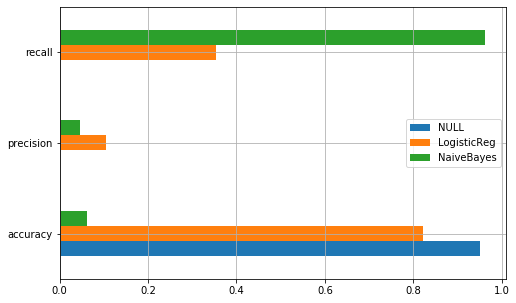

In [37]:
#визуализация
fig, ax = plt.subplots(figsize=(8,5)) 
metrics.plot(kind='barh', ax=ax)
ax.grid();

In [38]:
precision_nb, recall_nb, thresholds_nb = precision_recall_curve(y_true=y_test, 
                                                                probas_pred=NBC.predict_proba(X_test)[:,1])
precision_lr, recall_lr, thresholds_lr = precision_recall_curve(y_true=y_test, 
                                                                probas_pred=logistic_regression.predict_proba(X_test)[:,1])

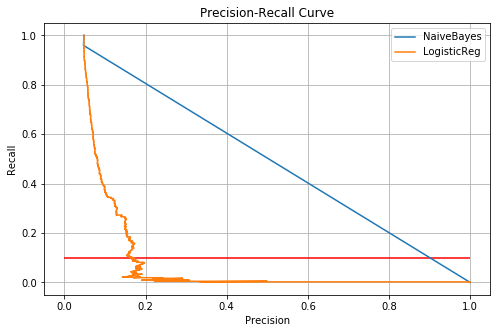

In [39]:
fig, ax = plt.subplots(figsize=(8,5))
ax.plot(precision_nb, recall_nb, label='NaiveBayes')
ax.plot(precision_lr, recall_lr, label='LogisticReg')
ax.set_xlabel('Precision')
ax.set_ylabel('Recall')
ax.set_title('Precision-Recall Curve')
ax.hlines(y=0.1, xmin=0, xmax=1, color='red')
ax.legend()
ax.grid(); 
# предсказания имеют низкое качество, требуются более сложные модели

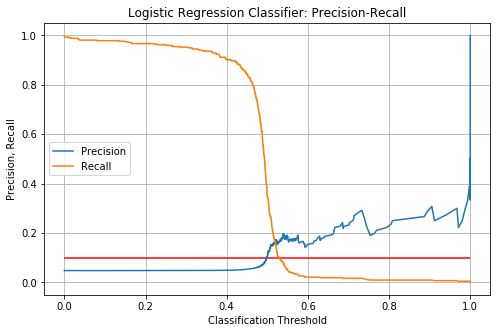

In [40]:
fig, ax = plt.subplots(figsize=(8,5))
ax.plot(thresholds_lr, precision_lr[1:], label='Precision')
ax.plot(thresholds_lr, recall_lr[1:], label='Recall')
ax.set_xlabel('Classification Threshold')
ax.set_ylabel('Precision, Recall')
ax.set_title('Logistic Regression Classifier: Precision-Recall')
ax.hlines(y=0.1, xmin=0, xmax=1, color='red')
ax.legend()
ax.grid();

In [41]:
y_pred_proba = logistic_regression.predict_proba(X_test)[:,1]
y_pred_test = (y_pred_proba >= 0.5).astype('int') 
# ставим порог 0.522, чтобы выравнять пресижн и реколл

CM = confusion_matrix(y_pred=y_pred_test, y_true=y_test)
print("Recall: ", 100*recall_score(y_pred=y_pred_test, y_true=y_test))
print("Precision: ", 100*precision_score(y_pred=y_pred_test, y_true=y_test))
CMatrix(CM) 
# теперь модель предсказывает равномерно плохо
# ситуативно, если мы это делаем для формирования рекламной рассылки для продвижения
# услуг по процедуре банкротства, то у нас цена ошибки низкая, так что в целом можем и по нецелевым таргетироваться, 
# тогда максимизируем Recall - в таком случае видим, что попали по 95% банкротов. Другое дело - низкая эффективность, 
# с таким же успехом мы можем сразу по всей базе рассылку делать

Recall:  35.406698564593306
Precision:  10.444601270289343


PREDICTION,not bankrupt,bankrupt,Total
TRUE,,,
not bankrupt,6994,1269,8263
bankrupt,270,148,418
Total,7264,1417,8681


In [42]:
# пробовал привести все цифры к единой длине, но не помогло. Вообще, маловероятно, 
# что такое в принципе помочь может, но на всякий случай попробовал
# до этого проверял на корреляции - данные не коррелируют
companies['x4'] = companies['x4']/10 
companies['x5'] = companies['x5']/100
companies['x8'] = companies['x8']/10
companies['x9'] = companies['x9']/10
companies['x15'] = companies['x15']/1000
companies['x17'] = companies['x17']/10
companies['x20'] = companies['x20']/100
companies['x28'] = companies['x28']/10
companies['x29'] = companies['x29']/10
companies['x32'] = companies['x32']/100
companies['x33'] = companies['x33']/10
companies['x36'] = companies['x36']/10
companies['x43'] = companies['x43']/1000
companies['x44'] = companies['x44']/1000
companies['x47'] = companies['x47']/100
companies['x50'] = companies['x50']/10
companies['x53'] = companies['x53']/100
companies['x54'] = companies['x54']/100
companies['x55'] = companies['x55']/1000000
companies['x61'] = companies['x61']/10
companies['x62'] = companies['x62']/1000
companies['x63'] = companies['x63']/10
companies['x64'] = companies['x64']/10

In [43]:
stat_companies = companies.corr() 
stat_companies = stat_companies.loc['bankrupt']
stat_companies = pd.DataFrame(stat_companies)    
stat_companies['abs'] = stat_companies['bankrupt'].apply(lambda x: abs(x))
    
stat_companies = stat_companies.sort_values(['abs'])
stat_companies[50:60] 
#они не коррелируют практически ни с чем, выравнивание тоже не помогло

,bankrupt,abs
x57,-0.019194,0.019194
x39,-0.019794,0.019794
x55,-0.022100,0.022100
x1,-0.026642,0.026642
x6,-0.034654,0.034654
x51,0.034743,0.034743
x3,-0.035119,0.035119
x2,0.035227,0.035227
x29,-0.055703,0.055703
bankrupt,1.000000,1.000000


In [44]:
logistic_regression = LogisticRegression(n_jobs=-1, random_state=15)
logistic_regression.fit(X_train, y_train)

y_pred_test = logistic_regression.predict(X_test)
metrics.loc['accuracy','LogisticReg'] = accuracy_score(y_pred=y_pred_test, y_true=y_test)
metrics.loc['precision','LogisticReg'] = precision_score(y_pred=y_pred_test, y_true=y_test)
metrics.loc['recall','LogisticReg'] = recall_score(y_pred=y_pred_test, y_true=y_test)

CM = confusion_matrix(y_pred=y_pred_test, y_true=y_test)
CMatrix(CM) 

# не, без толку. the game was rigged from the start

# проблема тут в данных. Возможно, слишком малый объем выборки, слишком мало банкротств, или нет релевантных признаков для предсказания 
# банкротства. Также можно попробовать другие предсказательные модели для бинарной классификации, или модели
# с комплексными условиями.

# также возможно, что мешает мультикоррелиарность (когда между собой нецелевые признаки коррелируют), так что требуется дополнительная проверка

# не всегда модели работают так, как нам хочется, и не каждая история - это история успеха

B:\python\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
B:\python\lib\site-packages\sklearn\linear_model\logistic.py:1544: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
B:\python\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


PREDICTION,not bankrupt,bankrupt,Total
TRUE,,,
not bankrupt,6994,1269,8263
bankrupt,270,148,418
Total,7264,1417,8681


### Логистическая регрессия: классификация текстов

#### Описание набора данных

Давайте предскажем спам в СМС сообщениях. Датасет включает в себя 5,572 текстовых сообщений и соответствующий им лейбл (целевой признак): 
- **ham**: 4,828 объектов
- **spam**: 747 объектов

In [45]:
sms = pd.read_table('SMSSpamCollection', header=None, names=['label', 'message'])
sms.head()

B:\python\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: read_table is deprecated, use read_csv instead, passing sep='\t'.
  """Entry point for launching an IPython kernel.


,label,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [46]:
# Преобразуем текстовые лейблы в численные
sms['target'] = (sms['label'] == 'spam').astype(int)
sms.drop('label', axis=1, inplace=True)
sms.head()

,message,target
0,"Go until jurong point, crazy.. Available only ...",0
1,Ok lar... Joking wif u oni...,0
2,Free entry in 2 a wkly comp to win FA Cup fina...,1
3,U dun say so early hor... U c already then say...,0
4,"Nah I don't think he goes to usf, he lives aro...",0


#### Немного про обработку текстов

Для того чтобы работать с текстами, необходимо представить сам текст в виде набора признаков. Существуют различные способы это сделать (учитывать частотут, векторизировать, работать с отдельным набором слов или словосочетаний) и так далее. Давайте посмотрим на самый простой способ - использовать одно слово как самостоятельный признак. Такая процедура позволяет представить любой корпус текстов как набор независимых (иногда, зависимых) векторов.

Для представления текста в виде набора признаков как правило выполняется два шага:
1. Создание словаря из корпуса, используя fit method.
2. Использование данного словаря для векторизации любого нового текста, используя transform method.

Представим, что у нас есть корпус:

In [47]:
corpus = [
          'This is the first document',
          'This is the second second document',
          'And the third one. Yes, yes, yes this',
          'Is this the first document?'
         ]

In [48]:
# Шаг 1: создание словаря
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer()
vectorizer.fit(corpus)

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
                lowercase=True, max_df=1.0, max_features=None, min_df=1,
                ngram_range=(1, 1), preprocessor=None, stop_words=None,
                strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, vocabulary=None)

In [49]:
# Как выглядит набор признаков?
vectorizer.get_feature_names()

['and',
 'document',
 'first',
 'is',
 'one',
 'second',
 'the',
 'third',
 'this',
 'yes']

In [50]:
# Шаг 2: векторизируем тексты (dtm: document-token matrix)
X_dtm = vectorizer.transform(corpus)

In [51]:
# Посмотрим, как теперь выглядит набор признаков для каждого отдельного документа (текста) в корпусе
pd.DataFrame(data=X_dtm.toarray(), columns=vectorizer.get_feature_names(), index=['doc_'+str(i+1) for i in range(4)])

,and,document,first,is,one,second,the,third,this,yes
doc_1,0,1,1,1,0,0,1,0,1,0
doc_2,0,1,0,1,0,2,1,0,1,0
doc_3,1,0,0,0,1,0,1,1,1,3
doc_4,0,1,1,1,0,0,1,0,1,0


Процедура прелставления текстов в векторном пространстве в таком виде известна как **модель мешка слов (Bag of Words)**.

Выполним следующую последовательность задач:
1. Подготовим данные для моделирования, сохранив отдельно предикторы и целевой признак. Разделим выборку на тестовую и тренировочную (параметры: `test_size=0.2, random_state=123`);
2. С помощью `CountVectorizer()` предобработаем корпус смс-сообщений тестовой и тренировочной выборки;
3. Оценим модель логистической регрессии и наивный байес. Сравним модели по метрикам качества и выберем лучшую;
4. Предскажем ham/spam для следующих смс-сообщений:
    - "Today is your lucky day! claim $100 of free gas now! just text back saying YES."
    - "I have been calling you all day, r u comming back before dinner?"

In [52]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, precision_recall_curve
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
#импортируем библиотеки

target_name = 'target'
robust_scaler = RobustScaler()

X = sms.drop('target', axis=1) #готовим датафрейм к моделированию

corpus = X['message']
vectorizer = CountVectorizer()
vectorizer.fit(corpus)
X_dtm = vectorizer.transform(corpus)
X = pd.DataFrame(data=X_dtm.toarray(), columns=vectorizer.get_feature_names(), index=['doc_'+str(i+1) for i in range(5572)]) #прописываем range
#предобрабатываем корпус смс-сообщений для тестовой и тренировочной выборок

X = robust_scaler.fit_transform(X)

y = sms[target_name]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

# позитивный класс: spam
# негативный класс: ham
# задача бинарной классификации

In [53]:
def CMatrix(CM, labels=['ham','spam']):
    df = pd.DataFrame(data=CM, index=labels, columns=labels)
    df.index.name='TRUE'
    df.columns.name='PREDICTION'
    df.loc['Total'] = df.sum()
    df['Total'] = df.sum(axis=1)
    return df

In [54]:
metrics = pd.DataFrame(index=['accuracy', 'precision', 'recall'], 
                      columns=['LogisticReg','NaiveBayes']) #в колонках логистическая и наивный баес
          

In [55]:
logistic_regression = LogisticRegression(n_jobs=-1, random_state=15)
logistic_regression.fit(X_train, y_train)

y_pred_test = logistic_regression.predict(X_test) 
metrics.loc['accuracy','LogisticReg'] = accuracy_score(y_pred=y_pred_test, y_true=y_test) #сохраняем 
metrics.loc['precision','LogisticReg'] = precision_score(y_pred=y_pred_test, y_true=y_test)
metrics.loc['recall','LogisticReg'] = recall_score(y_pred=y_pred_test, y_true=y_test)

CM = confusion_matrix(y_pred=y_pred_test, y_true=y_test)
CMatrix(CM)

B:\python\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
B:\python\lib\site-packages\sklearn\linear_model\logistic.py:1544: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


PREDICTION,ham,spam,Total
TRUE,,,
ham,960,2,962
spam,16,137,153
Total,976,139,1115


In [56]:
NBC = GaussianNB()
NBC.fit(X_train, y_train)

y_pred_test = NBC.predict(X_test)
metrics.loc['accuracy','NaiveBayes'] = accuracy_score(y_pred=y_pred_test, y_true=y_test)
metrics.loc['precision','NaiveBayes'] = precision_score(y_pred=y_pred_test, y_true=y_test)
metrics.loc['recall','NaiveBayes'] = recall_score(y_pred=y_pred_test, y_true=y_test)

CM = confusion_matrix(y_pred=y_pred_test, y_true=y_test)
CMatrix(CM)

PREDICTION,ham,spam,Total
TRUE,,,
ham,860,102,962
spam,16,137,153
Total,876,239,1115


In [57]:
#логистическая регрессия лучшая практически по всем показателям, а по recall одинаково
100*metrics

,LogisticReg,NaiveBayes
accuracy,98.3857,89.417
precision,98.5612,57.3222
recall,89.5425,89.5425


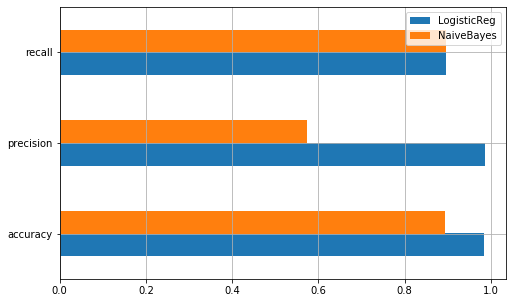

In [58]:
#визуально видим то же самое
fig, ax = plt.subplots(figsize=(8,5)) 
metrics.plot(kind='barh', ax=ax)
ax.grid();

In [60]:
#готовимся к визуализации
precision_nb, recall_nb, thresholds_nb = precision_recall_curve(y_true=y_test,  
                                                                probas_pred=NBC.predict_proba(X_test)[:,1])
precision_lr, recall_lr, thresholds_lr = precision_recall_curve(y_true=y_test, 
                                                                probas_pred=logistic_regression.predict_proba(X_test)[:,1])

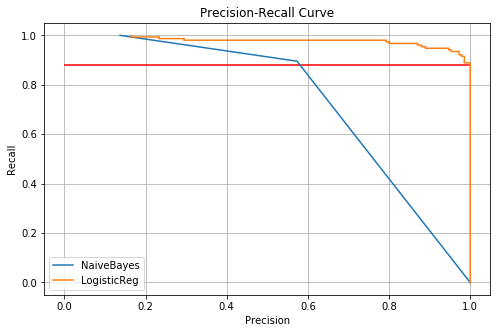

In [61]:
fig, ax = plt.subplots(figsize=(8,5))
ax.plot(precision_nb, recall_nb, label='NaiveBayes')
ax.plot(precision_lr, recall_lr, label='LogisticReg')
ax.set_xlabel('Precision')
ax.set_ylabel('Recall')
ax.set_title('Precision-Recall Curve')
ax.hlines(y=0.88, xmin=0, xmax=1, color='red')
ax.legend()
ax.grid();

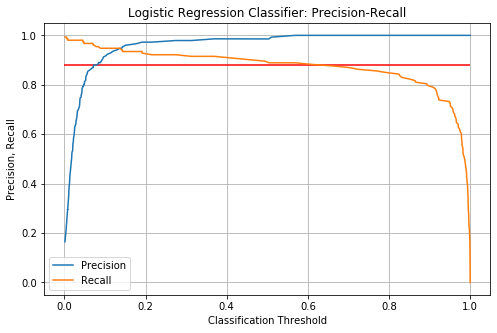

In [62]:
fig, ax = plt.subplots(figsize=(8,5))
ax.plot(thresholds_lr, precision_lr[1:], label='Precision')
ax.plot(thresholds_lr, recall_lr[1:], label='Recall')
ax.set_xlabel('Classification Threshold')
ax.set_ylabel('Precision, Recall')
ax.set_title('Logistic Regression Classifier: Precision-Recall')
ax.hlines(y=0.88, xmin=0, xmax=1, color='red') #линия на оптимальном для решения задачи показателе
ax.legend()
ax.grid();

In [63]:
y_pred_proba = logistic_regression.predict_proba(X_test)[:,1]
y_pred_test = (y_pred_proba >= 0.51).astype('int')  #при 0.51 меньше 1% важных писем уходит в спам, но фильтруется почти 89% спама.
                                                    #если повышать, то уже показатель лучше не сделать, но и понижать смысла нет
CM = confusion_matrix(y_pred=y_pred_test, y_true=y_test)
print("Recall: ", 100*recall_score(y_pred=y_pred_test, y_true=y_test))
print("Precision: ", 100*precision_score(y_pred=y_pred_test, y_true=y_test))
CMatrix(CM) 
# цена ошибки у нас высокая - мы не хотим, чтобы важное сообщение улетело в спам. Для минимизации
# false positive мы максимизируем Precision.

Recall:  88.88888888888889
Precision:  99.27007299270073


PREDICTION,ham,spam,Total
TRUE,,,
ham,961,1,962
spam,17,136,153
Total,978,137,1115


In [64]:
# у нас предсказательнай алгоритм работает по определенной таблице, так что нам подгонять под неё 
# новые сообщения

# для начала сохраним референсную таблицу, по которой у нас обучалась выборка 

B = sms.drop('target', axis=1)
corpus = B['message']
vectorizer = CountVectorizer()
vectorizer.fit(corpus)
X_dtm = vectorizer.transform(corpus)
B = pd.DataFrame(data=X_dtm.toarray(), columns=vectorizer.get_feature_names(), index=['doc_'+str(i+1) for i in range(len(B))])

len(B.columns) # колво колонок - 8713, и нам его необходимо сохранить

8713

In [65]:
# создаём датафрейм, к которому будем приделывать новые сообшения

Z = sms.drop('target', axis=1)
Z['message'].loc[len(Z)] = "Today is your lucky day! claim $100 of free gas now! just text back saying YES."
# приделываем сообщение в графу в конец

corpus = Z['message']
vectorizer = CountVectorizer()
vectorizer.fit(corpus)
X_dtm = vectorizer.transform(corpus)
Z = pd.DataFrame(data=X_dtm.toarray(), columns=vectorizer.get_feature_names(), index=['doc_'+str(i+1) for i in range(len(Z)+1)])

Z = Z.drop(Z.columns.difference(list(B)), axis=1) 
# таким образом мы дропаем несовпадабщие с референсным листом колонки и
# сохраняем колво колонок

In [66]:
Z[-1:] 
#добавилось новое сообщение в конец, на него и будем таргетироваться при предсказании

,00,000,000pes,008704050406,0089,0121,01223585236,01223585334,0125698789,02,...,zhong,zindgi,zoe,zogtorius,zoom,zouk,zyada,èn,ú1,〨ud
doc_5573,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [67]:
prob = logistic_regression.predict_proba(Z[-1:])[0][1] #таргетируемся

if prob >= 0.51: #используем найденные нами условия для классификации
    print ('spam') #правильно предсказали спам
else:
    print('ham') 

spam


In [68]:
#потом это можно использовать в более комплексных задачах
Z = sms.drop('target', axis=1)
Z['message'].loc[len(Z)] = "I have been calling you all day, r u comming back before dinner?"

corpus = Z['message']
vectorizer = CountVectorizer()
vectorizer.fit(corpus)
X_dtm = vectorizer.transform(corpus)
Z = pd.DataFrame(data=X_dtm.toarray(), columns=vectorizer.get_feature_names(), index=['doc_'+str(i+1) for i in range(len(Z)+1)])

Z = Z.drop(Z.columns.difference(list(B)), axis=1)

In [69]:
#количество колонок сохранено
len(Z.columns) 

8713

In [70]:
#место прошлого сообщения для предсказания заняло новое сообщение
Z[-1:] 

,00,000,000pes,008704050406,0089,0121,01223585236,01223585334,0125698789,02,...,zhong,zindgi,zoe,zogtorius,zoom,zouk,zyada,èn,ú1,〨ud
doc_5573,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [71]:
prob = logistic_regression.predict_proba(Z[-1:])[0][1]

if prob >= 0.51:
    print ('spam')
else:
    print('ham') #работает, правильно предсказали не-спам

ham
